# Pauli Transfer Matrix

In [1]:
import numpy as np; pi = np.pi
import matplotlib.pyplot as plt

In [2]:
from qutip import *
from qutip.qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import *

In [3]:
from cvqaoa.cvdevice import KPOProcessor

In [4]:
%reload_ext autoreload
%autoreload 2

In this notebook we extract the error channels for the Kerr-parametric oscillator

### Setup parameters

In [5]:
## KPO parameters
kpo = KPOProcessor(N=1,num_lvl=16)
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']

## Cat state
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

## Computational basis
up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

## Pauli Matrices in computational basis
# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())
sigma = [I, sigma_x, sigma_y, sigma_z]

#### RZ

In [6]:
# Angle of rotation
arg = pi/4

# Quantum circuit
qc = QubitCircuit(1)
qc.add_gate("RZ",0,None,arg)

d = 2 # dimension
# pauli transfer matrix
R = np.zeros((d**2,d**2)) 
R_inv = np.zeros((d**2,d**2)) # inverse/ideal
for j in range(d**2):
    result = kpo.run_state(init_state=sigma[j],qc=qc,noisy=True)
    result_inv = kpo.run_state(init_state=sigma[j],qc=qc,noisy=False)
    
    Lambda = result.states[-1]
    Lambda_inv = result_inv.states[-1]
    for i in range(d**2):
        R[i,j] = 1/d * ((sigma[i]*Lambda).tr()).real
        R_inv[i,j] = 1/d * ((sigma[i]*Lambda_inv).tr()).real

Let $R_U$ correspond to the PTM of the ideal gate $U$, and let $R_\tilde{U}$ correspond to the noisy implementation of $U$.

The PTM of the error channel can thus be extracted by
$$
R_\mathcal{E} = R_U (R_\tilde{U})^{-1}
$$

In [7]:
error_channel = np.around(R @ np.linalg.inv(R_inv), 3)
Qobj(error_channel)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1.    0.    0.    0.   ]
 [0.    0.989 0.    0.   ]
 [0.    0.    0.989 0.   ]
 [0.    0.    0.    1.   ]]

In [11]:
file = 'ptm_error_channel_rz'
np.save(file, error_channel, allow_pickle=True, fix_imports=True)

#### Convert PTM to chi matrix

$$
R_{ij} = \frac{1}{d}\sum_{mn}\chi_{mn} \mathrm{Tr}(P_iP_mP_jP_n)
$$
This equation can be vectorized

$$
\vec R = \frac{1}{d} A \vec\chi
$$
where 
$$
A_{(mn,ij)} = \mathrm{Tr}(P_iP_mP_jP_n)
$$
and then solved
$$
d (A^{-1}\vec R)  = \vec\chi
$$

In [9]:
A = np.zeros((4,4,4,4),dtype='complex')
P = [qeye(2),sigmax(),sigmay(),sigmaz()]
for i in range(4):
    for j in range(4):
        for m in range(4):
            for n in range(4):
                A[i,j,m,n] = (P[i]*P[m]*P[j]*P[n]).tr()
A = A.reshape((16,16))
A_inv = np.linalg.inv(A)

In [10]:
chi = d*Qobj((A_inv @ error_channel.reshape((4**2,1))).reshape((4,4)),dims=[[[2],[2]],[[2],[2]]],superrep='chi')

In [23]:
choi = chi_to_choi(chi)
kraus = choi_to_kraus(choi)
kraus = [d*k.full() for k in kraus]

In [20]:
file = 'cv_kraus_rz'
np.save(file, kraus, allow_pickle=True, fix_imports=True)

#### RX

In [33]:
# Angle of rotation 
arg_list = np.linspace(0, np.pi, num=181, endpoint=False)

d = 2 # dimension
# pauli transfer matrix
R = np.zeros((d**2,d**2)) 
R_inv = np.zeros((d**2,d**2)) # inverse

error_channel = np.zeros((len(arg_list), d**2, d**2))

for idx, arg in enumerate(arg_list):
    # Quantum circuit
    qc = QubitCircuit(1)
    qc.add_gate("RX",0,None,arg)
    
    # loading
    if idx % 10 == 0 :
        print(idx)
        
    for j in range(d**2):
        result = kpo.run_state(init_state=sigma[j],qc=qc,noisy=True)
        result_inv = kpo.run_state(init_state=sigma[j],qc=qc,noisy=False)

        Lambda = result.states[-1]
        Lambda_inv = result_inv.states[-1]
        for i in range(d**2):
            R[i,j] = 1/d * ((sigma[i]*Lambda).tr()).real
            R_inv[i,j] = 1/d * ((sigma[i]*Lambda_inv).tr()).real
            
    error_channel[idx,:,:] = np.around(R @ np.linalg.inv(R_inv), 3)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180


In [40]:
file = 'ptm_error_channel_rx'
np.save(file, error_channel, allow_pickle=True, fix_imports=True)

In [175]:
file = 'ptm_error_channel_rx.npy'
error_channel = np.load(file)

In [198]:
d = 2
kraus = []
for error in error_channel:
    chi = d*Qobj((A_inv @ error.reshape((4**2,1))).reshape((4,4)),dims=[[[2],[2]],[[2],[2]]],superrep='chi')
    choi = chi_to_choi(chi)
    kraus_list = choi_to_kraus(choi)
    kraus.append([d*k.full() for k in kraus_list])

In [199]:
Qobj(sum(k@np.conjugate(k.T) for k in kraus[1]))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1.00001999e+00+0.00000000e+00j 1.68922798e-19+1.29054604e-19j]
 [1.68922798e-19-1.29054604e-19j 1.00001999e+00+0.00000000e+00j]]

In [207]:
kraus

[[array([[0.98742088+0.j, 0.        +0.j],
         [0.        +0.j, 0.98742088+0.j]]),
  array([[ 0.15811388+0.j,  0.        +0.j],
         [ 0.        +0.j, -0.15811388+0.j]])],
 [array([[ 9.87420883e-01+2.13003225e-20j,  1.01087288e-19+5.91408570e-20j],
         [-3.51089358e-17-2.90973016e-19j,  9.87420883e-01-8.55440279e-20j]]),
  array([[ 1.58113896e-01-1.49608617e-18j, -6.02537553e-19-3.16101401e-03j],
         [ 2.19135912e-16+3.16101401e-03j, -1.58113896e-01+1.86589463e-18j]]),
  array([[-6.31950123e-05-1.10058712e-19j,  1.53790905e-16-3.16101401e-03j],
         [ 7.27702169e-17+3.16101401e-03j,  6.31950123e-05+4.56728981e-19j]])],
 [array([[ 9.87674035e-01+1.25243420e-20j, -3.08362476e-20-1.13579557e-19j],
         [ 3.97803653e-16-2.72117689e-19j,  9.87674035e-01-4.06518812e-20j]]),
  array([[ 1.56524772e-01+1.18711525e-17j, -5.01960563e-20-3.19305377e-03j],
         [-2.50892092e-15+3.19305377e-03j, -1.56524772e-01-1.13974175e-17j]]),
  array([[ 6.51372447e-05-1.34052042e-

In [208]:
kraus = np.array(kraus,dtype='object')

In [210]:
file = 'cv_kraus_rx'
np.save(file, kraus, allow_pickle=True, fix_imports=True)

In [548]:
x_data = arg_list[:-1]

p_11 = np.polyfit(x_data, error_channel[:,1,1][:-1], 4)
p_22 = np.polyfit(x_data, error_channel[:,2,2][:-1], 4)
p_33 = np.polyfit(x_data, error_channel[:,3,3][:-1], 4)
p_23 = np.polyfit(x_data, error_channel[:,2,3][:-1], 4)
p_32 = np.polyfit(x_data, error_channel[:,3,2][:-1], 4)

In [542]:
def err_rx(theta):
    data = np.array(
        [[1,0,0,0],
         [0,np.poly1d(p_11)(theta),0,0],
         [0,0,np.poly1d(p_22)(theta),np.poly1d(p_23)(theta)],
         [0,0,np.poly1d(p_32)(theta),np.poly1d(p_33)(theta)]]
         )
    return data

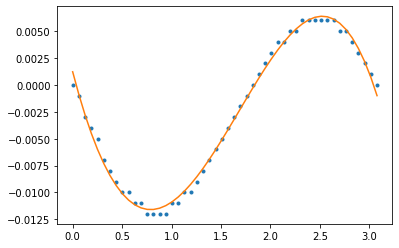

In [545]:
plt.plot(x_data, y_data, '.')
plt.plot(x_data, np.poly1d(params)(x_data), label='Fitted function')

#### $U(\Theta)$-gate (Constant amplitude)

In [106]:
def carb(arg_value):
    # control arbitrary phase gate
    zz = tensor(sigmaz(),sigmaz())
    return (-1j*arg_value/2*zz).expm()

In [68]:
kpo = KPOProcessor(N=2,num_lvl=14) # create two resonators

alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']

## Cat state
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

## Computational basis
up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

## Pauli Matrices in computational basis
# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())
sigma = [I, sigma_x, sigma_y, sigma_z]

# Pauli matrices
d = 4
Q = []
for i in range(d):
    Q.extend([tensor(sigma[i], sigma[j]) for j in range(d)])

In [163]:
arg = pi/2

## Create quantum circuit
qc = QubitCircuit(N=1)
qc.user_gates = {"CARB": carb}
qc.add_gate("CARB", targets = [0,1], arg_value = arg)
    
# pauli transfer matrix
R = np.zeros((d**2,d**2))
R_inv = np.zeros((d**2,d**2)) # inverse

for j in range(d**2):
    result = kpo.run_state(init_state=Q[j],qc=qc,noisy=True)
    result_inv = kpo.run_state(init_state=Q[j],qc=qc,noisy=False)
    
    Lambda = result.states[-1]
    Lambda_inv = result_inv.states[-1]
    for i in range(d**2):
        R[i,j] = 1/d * np.real((Q[i]*Lambda).tr())
        R_inv[i,j] = 1/d * np.real((Q[i]*Lambda_inv).tr())
        
R = Qobj(R,dims=[[2]*2]*2) # Make quantum object
R_inv = Qobj(R_inv,dims=[[2]*2]*2) # Make quantum object

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [177]:
error_channel = np.around(R.full() @ np.linalg.inv(R_inv.full()), 3)

### save file

In [165]:
file = 'ptm_error_channel_ising_zz'
np.save(file, error_channel, allow_pickle=True, fix_imports=True)

### load file

In [66]:
file = 'ptm_error_channel_ising_zz.npy'
error_channel = np.load(file)

array([1.   , 0.989, 0.989, 1.   , 0.989, 0.979, 0.979, 0.989, 0.989,
       0.979, 0.979, 0.989, 1.   , 0.989, 0.989, 1.   ])

In [69]:
A = np.zeros((16,16,16,16),dtype='complex')
for i in range(16):
    for j in range(16):
        for m in range(16):
            for n in range(16):
                A[i,j,m,n] = (Q[i]*Q[m]*Q[j]*Q[n]).tr()
#A = A.reshape((16,16))
#A_inv = np.linalg.inv(A)

In [98]:
A = A.reshape((16**2,16**2))
A_inv = np.linalg.inv(A)

In [107]:
error_channel.reshape((16**2,1)).shape

(256, 1)

In [108]:
A_inv.shape

(256, 256)

In [101]:
A_inv @ error_channel

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 16 is different from 256)

In [137]:
d = 4
chi = d*Qobj((A_inv @ error_channel.reshape((16**2,1))).reshape((16,16)),dims=[[[2,2],[2,2]],[[2,2],[2,2]]],superrep='chi')

In [169]:
choi = chi_to_choi(chi)
kraus = choi_to_kraus(choi)
kraus = [d*k.full() for k in kraus]

In [172]:
Qobj(sum(k@np.conjugate(k.T) for k in kraus))

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

In [173]:
kraus

[array([[0.99461048+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.99461048+0.j, 0.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j, 0.99461048+0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.99461048+0.j]]),
 array([[ 1.02469508e-01+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j],
        [ 0.00000000e+00+0.j, -6.56672955e-16+0.j,  0.00000000e+00+0.j,
          0.00000000e+00+0.j],
        [ 0.00000000e+00+0.j,  0.00000000e+00+0.j, -6.56672955e-16+0.j,
          0.00000000e+00+0.j],
        [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         -1.02469508e-01+0.j]]),
 array([[ 0.01581139+0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j, -0.01581139+0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j, -0.01581139+0.j,
          0.        +0.j],
        [ 0.        +0.j,  

In [174]:
file = 'cv_kraus_zz'
np.save(file, kraus, allow_pickle=True, fix_imports=True)